<a href="https://colab.research.google.com/github/hardscrey/bank_customer_churn-prediction/blob/main/bank_customer_churn-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Поиск взаимосвязей, построение модели классификации (bank_customer_churn-prediction)
**Цель проекта:**
- Выявить признаки с наибольшим влиянием на отток и определиь характер их воздействия
- Построить модель классификации клиентов

**Структура ноутбука:**

0. Поиск взаимосвязей, построение модели классификации (bank_customer_churn-prediction)
1. Установка зависимостей
2. Параметры и загрузка данных
3. Предобработка: очистка, удаление лишних колонок, кодирование
4. Feature Engineering
5. Баланс классов
6. Корреляции — phik (подходит и для числовых и категориальных данных)
7. EDA — ключевые графики с краткими текстовыми интерпретациями
8. Подготовка данных для моделирования
9. Базовое сравнение моделей (быстрая оценка)
10. GridSearchCV: подбор гиперпараметров для RandomForest и XGBoost
11. Окончательная оценка моделей: train/test метрики (проверка переобучения)
12. ROC-кривые и Precision-Recall кривые
13. Confusion Matrix и Classification Report для лучшей модели
14. Feature importance(важность признаков) и SHAP-анализ (объяснение модели)
15. Финальные выводы
> Все результаты сохраняются в папках `images/` и `results/` (они будут созданы автоматически).

# 0) Установка зависимостей

In [87]:
!pip install phik xgboost shap matplotlib seaborn joblib

In [88]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import zipfile
from sklearn.utils import resample

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve, precision_recall_curve,
    auc
)

import phik
from phik import report
import shap


In [89]:
# Настройки отображения
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_columns', None)

In [90]:
# Папки для артефактов
os.makedirs('images', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('model_comparison', exist_ok=True)

# 1) Параметры и загрузка данных

In [91]:
# Укажите путь к локальному CSV (загрузите файл в Colab или поместите рядом с .ipynb)
path = 'Churn_Modelling.csv'

In [92]:
df = pd.read_csv(path)
print('Размер датасета:', df.shape)
display(df.head(5))

Размер датасета: (10002, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


Описание фич:

`Customer ID` - A unique identifier for each customer

`Surname` - The customer's surname or last name

`Credit Score` - A numerical value representing the customer's credit score

`Geography` - The country where the customer resides (France, Spain or Germany)

`Gender` - The customer's gender (Male or Female)

`Age` - The customer's age.

`Tenure` - The number of years the customer has been with the bank

`Balance` - The customer's account balance

`NumOfProducts` - The number of bank products the customer uses (e.g., savings account, credit card)

`HasCrCard` - Whether the customer has a credit card (1 = yes, 0 = no)

`IsActiveMember` - Whether the customer is an active member (1 = yes, 0 = no)

`EstimatedSalary` - The estimated salary of the customer

`Exited` - Whether the customer has churned (1 = yes, 0 = no)

# 2) Предобработка: очистка, удаление лишних колонок, кодирование
- Удаляем RowNumber, CustomerId, Surname (неинформативные)
- Кодируем Gender и Geography
- Удаляем дубликаты и NA

In [93]:
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], errors='ignore')
df = df.dropna().drop_duplicates().reset_index(drop=True)
print('После удаления дубликатов и лишних колонок:', df.shape)

После удаления дубликатов и лишних колонок: (9996, 11)


In [94]:
# Кодирование
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
# Geography в числовые коды (0,1,2)
df['Geography'] = df['Geography'].astype('category').cat.codes

In [95]:
# Убедимся
display(df.info())
display(df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9996 entries, 0 to 9995
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      9996 non-null   int64  
 1   Geography        9996 non-null   int8   
 2   Gender           9996 non-null   int64  
 3   Age              9996 non-null   float64
 4   Tenure           9996 non-null   int64  
 5   Balance          9996 non-null   float64
 6   NumOfProducts    9996 non-null   int64  
 7   HasCrCard        9996 non-null   float64
 8   IsActiveMember   9996 non-null   float64
 9   EstimatedSalary  9996 non-null   float64
 10  Exited           9996 non-null   int64  
dtypes: float64(5), int64(5), int8(1)
memory usage: 790.8 KB


None

,count,mean,std,min,25%,50%,75%,max
CreditScore,9996.0,650.503301,96.624668,350.00,584.00,652.00,717.2500,850.00
Geography,9996.0,0.746399,0.827499,0.00,0.00,0.00,1.0000,2.00
Gender,9996.0,0.545618,0.497940,0.00,0.00,1.00,1.0000,1.00
Age,9996.0,38.921071,10.488421,18.00,32.00,37.00,44.0000,92.00
Tenure,9996.0,5.013305,2.892353,0.00,3.00,5.00,7.2500,10.00
Balance,9996.0,76476.263216,62397.118820,0.00,0.00,97173.29,127639.3725,250898.09
NumOfProducts,9996.0,1.530212,0.581684,1.00,1.00,1.00,2.0000,4.00
HasCrCard,9996.0,0.705482,0.455849,0.00,0.00,1.00,1.0000,1.00
IsActiveMember,9996.0,0.514906,0.499803,0.00,0.00,1.00,1.0000,1.00
EstimatedSalary,9996.0,100106.701248,57513.314398,11.58,51002.11,100238.11,149400.1075,199992.48


# 3) Feature Engineering
BalanceGeoDiff - определяется разницей между балансом клиента и средним балансом по его стране

In [96]:
geo_mean = df.groupby('Geography')['Balance'].transform('mean')
df['BalanceGeoDiff'] = df['Balance'] - geo_mean


# 4) Баланс классов
Сначала посмотрим на баланс, затем выполним downsampling большинства, чтобы сделать классы сбалансированными


In [97]:
display(df['Exited'].value_counts())

,count
Exited,
0,7959
1,2037


In [98]:
# Балансировка
major = df[df['Exited'] == 0]
minor = df[df['Exited'] == 1]
print('Размеры классов:', len(major), len(minor))
major_down = resample(major, replace=False, n_samples=len(minor), random_state=42)
df_bal = pd.concat([major_down, minor]).sample(frac=1, random_state=42).reset_index(drop=True)

print('Классы после балансировки:')
display(df_bal['Exited'].value_counts())


Размеры классов: 7959 2037
Классы после балансировки:


,count
Exited,
0,2037
1,2037


# 5) Корреляции — phik
phik дает более адекватную зависимость для смешанных типов данных чем corr


In [99]:
phik_matrix = df_bal.phik_matrix()

interval columns not set, guessing: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'BalanceGeoDiff']


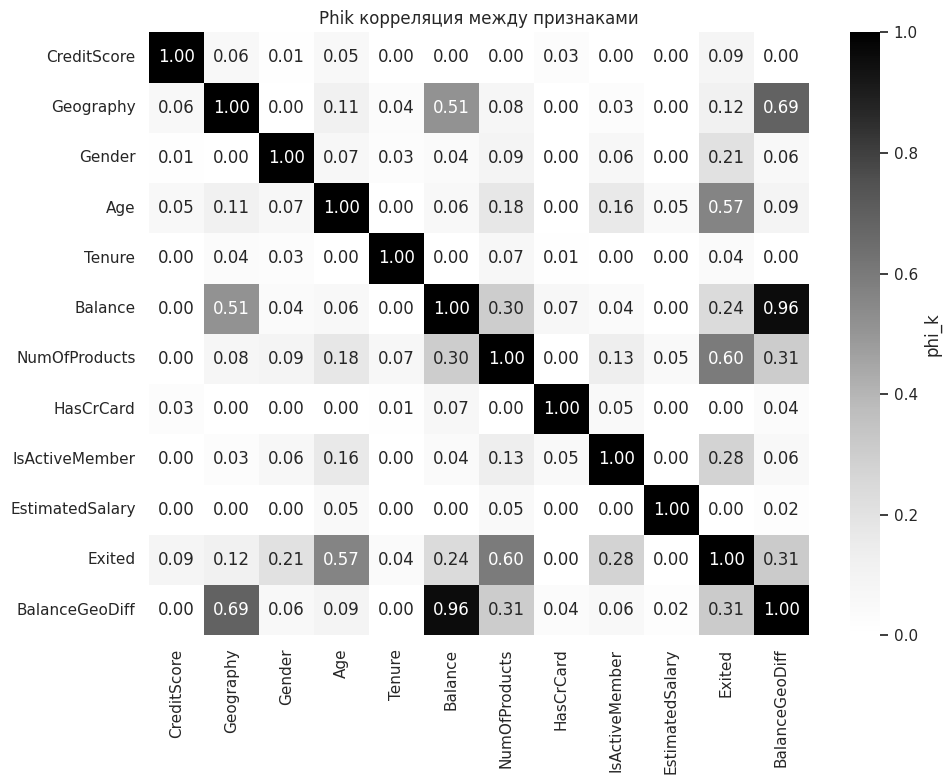

In [100]:
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix, annot=True, fmt='.2f', cmap='Greys', cbar_kws={'label':'phi_k'})
plt.title('Phik корреляция между признаками')
plt.tight_layout()
plt.savefig('images/phik_correlation.png', dpi=200)
plt.show()

По heatmap ясно видно наличие взаимосвязи между признаками, рассмотрим их подробнее в следующем разделе

# 6) EDA — ключевые графики с краткими текстовыми интерпретациями
Построим несколько информативных графиков: распределение NumOfProducts, Age, BalanceGeoDiff, IsActiveMember, Balance, Gender


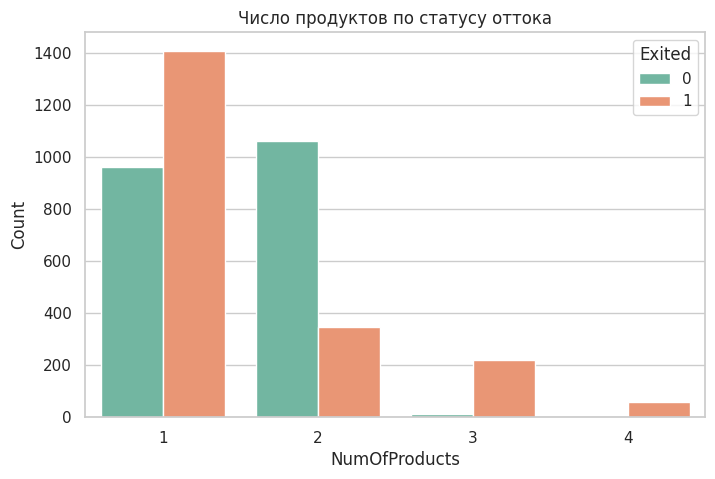

In [101]:
# NumOfProducts
plt.figure(figsize=(8,5))
sns.countplot(x='NumOfProducts', hue='Exited', data=df_bal, palette=['#66c2a5','#fc8d62'])
plt.title('Число продуктов по статусу оттока')
plt.xlabel('NumOfProducts')
plt.ylabel('Count')
plt.savefig('images/numofproducts_count.png', dpi=200)
plt.show()

Клиенты имеющие 3 или 4 продукта уходят в боьшинстве случаев, также большая часть клиентов с 1 продуктом оттекает, при этом клиенты с 2 продуктами чаще всего остаются

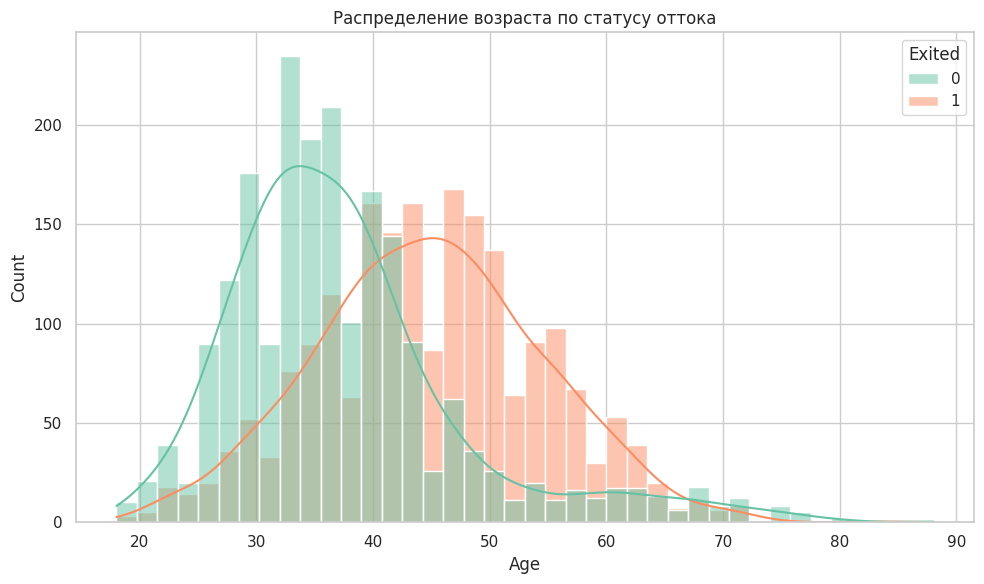

In [102]:
# Age
plt.figure()
sns.histplot(data=df_bal, x='Age', hue='Exited', bins=40, kde=True, palette=['#66c2a5','#fc8d62'])
plt.title('Распределение возраста по статусу оттока')
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('images/age_distribution.png', dpi=200)
plt.show()

К оттоку больше всего склонны клиенты возрастом 40-50 лет и более возрастные, клиенты 30-40 лет и младше чаще остаются

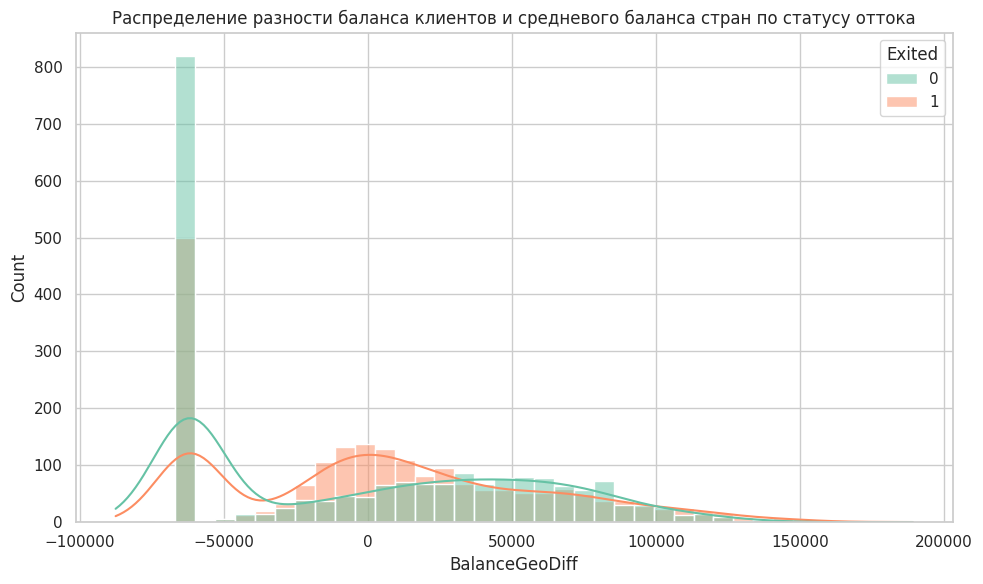

In [103]:
# BalanceGeoDiff
plt.figure()
sns.histplot(data=df_bal, x='BalanceGeoDiff', hue='Exited', bins=40, kde=True, palette=['#66c2a5','#fc8d62'])
plt.title('Распределение разности баланса клиентов и средневого баланса стран по статусу оттока')
plt.xlabel('BalanceGeoDiff')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('images/balancegeodiff_distribution.png', dpi=200)
plt.show()

Чаще всего оттекают клиенты с балансом равным среднему балансу клиентов страны к которой они относятся, люди с относительно высоким балансом чаще остаются, также есть группа улиентов с нулевым балансом  часть из который оттекает

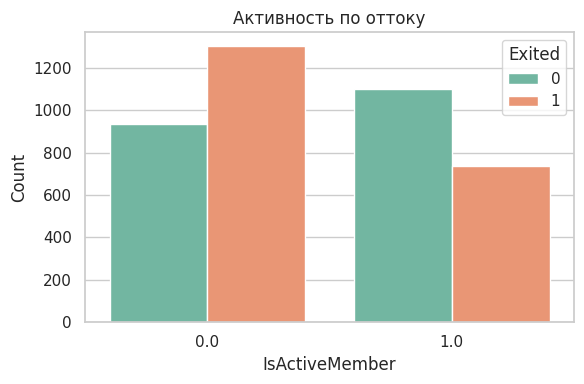

In [104]:
# IsActiveMember
plt.figure(figsize=(6,4))
sns.countplot(x='IsActiveMember', hue='Exited', data=df_bal, palette=['#66c2a5','#fc8d62'])
plt.title('Активность по оттоку')
plt.xlabel('IsActiveMember')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('images/active_by_exited.png', dpi=200)
plt.show()

Пассивные клиенты оттекают чаще, а пактивные чаще остаются

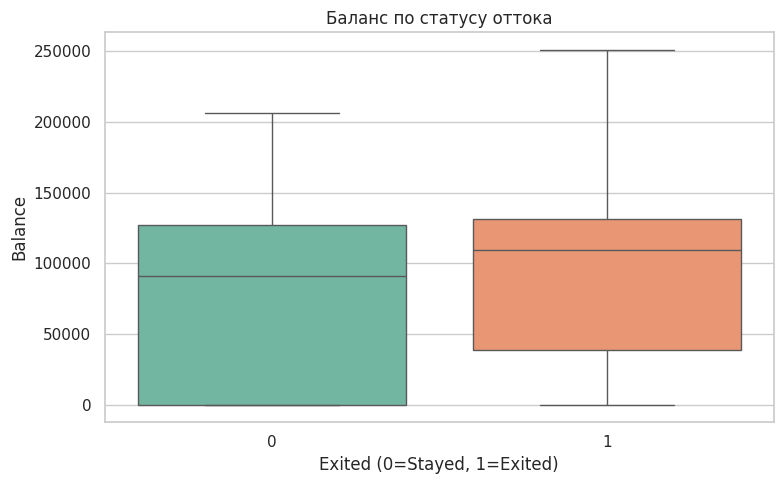

In [105]:
# Balance
plt.figure(figsize=(8,5))
sns.boxplot(x='Exited', y='Balance', data=df_bal, palette=['#66c2a5','#fc8d62'])
plt.title('Баланс по статусу оттока')
plt.xlabel('Exited (0=Stayed, 1=Exited)')
plt.ylabel('Balance')
plt.tight_layout()
plt.savefig('images/balance_boxplot.png', dpi=200)
plt.show()

Клиенты с более высоким средним балансом и содержащие большие суммы склонны уходить, а клиенты с низкими блалансами чаще остаются

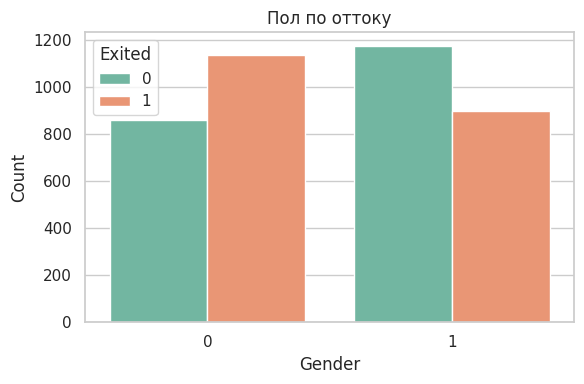

In [106]:
# Gender
plt.figure(figsize=(6,4))
sns.countplot(x='Gender', hue='Exited', data=df_bal, palette=['#66c2a5','#fc8d62'])
plt.title('Пол по оттоку')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('images/gender_by_exited.png', dpi=200)
plt.show()

Клиенты 0 гендера чаще оттекают, а клиенты 1 - остаются

# 7) Подготовка данных для моделирования
- масштабируем все признаки (StandardScaler)
- stratify по y, чтобы доля в трейне/тесте сохранялась


In [107]:
X = df_bal.drop(columns=['Exited'])
y = df_bal['Exited']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

print('Train/test shapes:', X_train.shape, X_test.shape)

Train/test shapes: (2851, 11) (1223, 11)


In [108]:
X_train

array([[-0.10683494,  0.29253526,  0.9824804 , ...,  1.10351544,
        -0.26363598,  0.52175515],
       [-1.25817037,  0.29253526, -1.01783201, ...,  1.10351544,
        -1.70728273,  0.1838896 ],
       [-2.18535201,  0.29253526,  0.9824804 , ...,  1.10351544,
        -1.63612965, -1.15851176],
       ...,
       [-0.78948515, -0.95934358, -1.01783201, ...,  1.10351544,
         1.29083475, -1.14707233],
       [ 0.77959145,  1.54441411, -1.01783201, ...,  1.10351544,
        -0.94145974,  0.7477937 ],
       [ 0.6063817 , -0.95934358, -1.01783201, ...,  1.10351544,
        -1.00998108, -1.14707233]])

# 8) Базовое сравнение моделей (быстрая оценка)
LogisticRegression, RandomForest, XGBoost

In [109]:
base_models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
}

base_results = []
for name, model in base_models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    metrics = {
        'model': name,
        'train_acc': accuracy_score(y_train, y_pred_train),
        'test_acc': accuracy_score(y_test, y_pred_test),
        'train_auc': roc_auc_score(y_train, model.predict(X_train)),
        'test_auc': roc_auc_score(y_test, y_pred_test)
    }
    base_results.append(metrics)

base_df = pd.DataFrame(base_results).set_index('model')
display(base_df.round(3))
base_df.to_csv('model_comparison/base_model_comparison.csv')

,train_acc,test_acc,train_auc,test_auc
model,,,,
LogisticRegression,0.697,0.718,0.697,0.718
RandomForest,1.000,0.789,1.000,0.789
XGBoost,0.990,0.769,0.990,0.769


По результатам тестирования моделей, можно заключить что RFC и XGB показывают наилучшие результаты, рассмотрим их подробнее

# 9) GridSearchCV: подбор гиперпараметров для RandomForest и XGBoost

In [110]:
# Grid для RandomForest
rf_param_grid = {
    'n_estimators': [150, 200, 250],
    'max_depth': [None, 6, 7, 8],
    'min_samples_leaf': [2, 4, 8]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid=rf_param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)
print('RF best params:', rf_grid.best_params_)
print('RF best cv score:', rf_grid.best_score_)

best_rf = rf_grid.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
RF best params: {'max_depth': 7, 'min_samples_leaf': 4, 'n_estimators': 200}
RF best cv score: 0.8519504785765173


In [111]:
# Grid для XGBoost
xgb_param_grid = {
    'n_estimators': [150, 193, 250],
    'max_depth': [1, 3, 5],
    'learning_rate': [0.03, 0.05, 0.07]
}

xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1), param_grid=xgb_param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)
print('XGB best params:', xgb_grid.best_params_)
print('XGB best cv score:', xgb_grid.best_score_)

best_xgb = xgb_grid.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
XGB best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 193}
XGB best cv score: 0.8570999145514382


При помощи GridSearch были определены лучший параметры для моделей, далее выберем лучшую из них.

# 10) Окончательная оценка моделей: train/test метрики (проверка переобучения)
Сравним: LogisticRegression (базовый), best_rf, best_xgb

In [112]:
models_to_eval = {
    'Best_RandomForest': best_rf,
    'Best_XGBoost': best_xgb
}

In [113]:
metrics_list = []
for name, model in models_to_eval.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    y_prob_train = model.predict_proba(X_train)[:, 1]
    y_prob_test = model.predict_proba(X_test)[:, 1]

    metrics_list.append({
        'model': name,
        'train_accuracy': accuracy_score(y_train, y_pred_train),
        'test_accuracy': accuracy_score(y_test, y_pred_test),
        'train_precision': precision_score(y_train, y_pred_train),
        'test_precision': precision_score(y_test, y_pred_test),
        'train_recall': recall_score(y_train, y_pred_train),
        'test_recall': recall_score(y_test, y_pred_test),
        'train_f1': f1_score(y_train, y_pred_train),
        'test_f1': f1_score(y_test, y_pred_test),
        'train_auc': roc_auc_score(y_train, y_prob_train),
        'test_auc': roc_auc_score(y_test, y_prob_test)
    })

In [114]:
metrics_df = pd.DataFrame(metrics_list).set_index('model')
metrics_df.to_csv('model_comparison/final_model_metrics.csv')
display(metrics_df.round(3))

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
model,,,,,,,,,,
Best_RandomForest,0.831,0.786,0.854,0.805,0.799,0.755,0.826,0.779,0.914,0.873
Best_XGBoost,0.805,0.786,0.822,0.798,0.779,0.764,0.800,0.781,0.892,0.874


На тренировочной выборке RFC показывает лучшие результаты, однко уступает на тестовой, эхто может говорить о переобучении или нехватки данных.


# 11) ROC-кривые и Precision-Recall кривые
Сравним лучшие модели на одном графике.


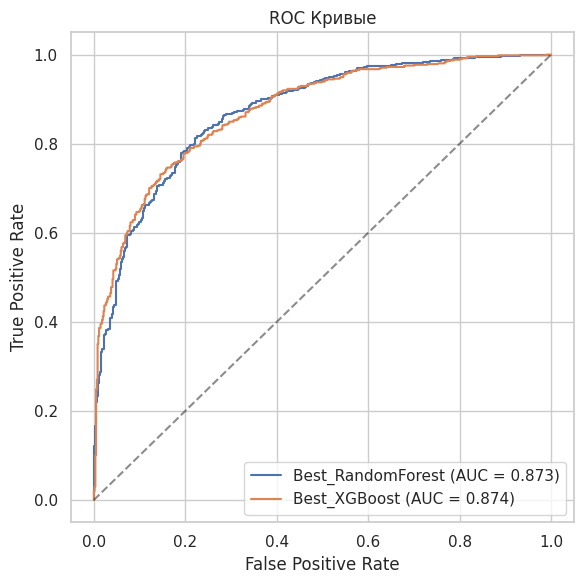

In [115]:
plt.figure(figsize=(6,6))
for name, model in models_to_eval.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Кривые')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('images/roc_comparison.png', dpi=200)
plt.show()

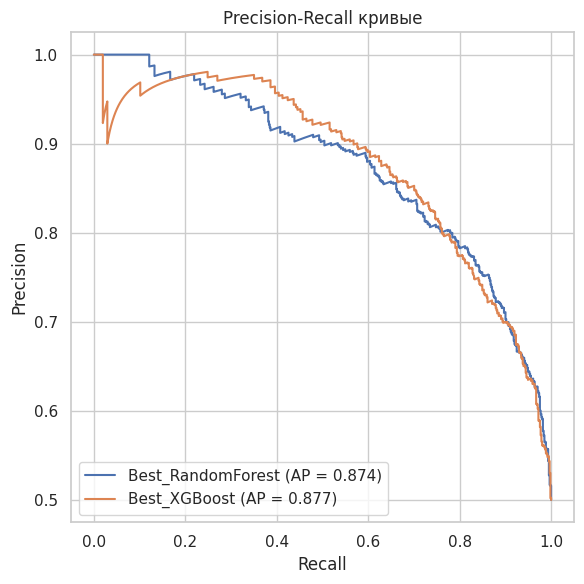

In [116]:
# Precision-Recall
plt.figure(figsize=(6,6))
for name, model in models_to_eval.items():
    y_prob = model.predict_proba(X_test)[:,1]
    prec, rec, _ = precision_recall_curve(y_test, y_prob)
    ap = auc(rec, prec)
    plt.plot(rec, prec, label=f'{name} (AP = {ap:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривые')
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig('images/pr_comparison.png', dpi=200)
plt.show()

Модели имеют схожие показатели на графиках.

# 12) Confusion Matrix и Classification Report для лучшей модели
Выберем лучшую модель по test_auc


In [117]:
# Найдём лучшую по test_auc
best_model_name = metrics_df['test_auc'].idxmax()
print('Лучшая модель по показателю AUC:', best_model_name)
best_model = models_to_eval[best_model_name]

Лучшая модель по показателю AUC: Best_XGBoost


In [118]:
# predictions
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:,1]

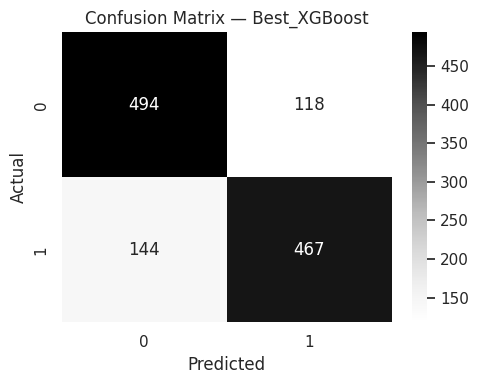

In [119]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys')
plt.title(f'Confusion Matrix — {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('images/confusion_matrix_best.png', dpi=200)
plt.show()

In [120]:
print('Classification report (best model):')
print(classification_report(y_test, y_pred_best))

Classification report (best model):
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       612
           1       0.80      0.76      0.78       611

    accuracy                           0.79      1223
   macro avg       0.79      0.79      0.79      1223
weighted avg       0.79      0.79      0.79      1223



# 13) Feature importance(важность признаков) и SHAP-анализ (объяснение модели)
Определим самые важные признаки и их влияние на отток.


In [121]:
# Значимость признаков
feat_imp = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)

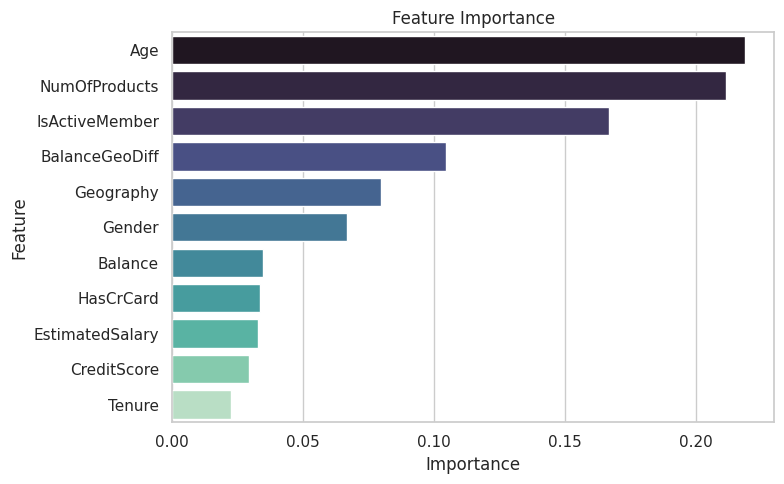

In [122]:
plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='mako')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('images/feature_importance.png', dpi=200)
plt.show()

Наибольшее влияние на отток имеют Возраст, Количество продуктов и Активность участников.

SHAP даёт более подробное объяснение. Построим SHAP summary plot(глобальный показатель влияния признаков) и зависимость для топ-2 признаков.

In [123]:
# SHAP explanation

# Расчитаем значения SHAP, которые помогают понять, как каждый признак влияет на предсказания модели.
# Мы используем универсальный SHAP Explainer, который работает, оборачивая функцию предсказания модели.

# Определим функцию-обертку для метода predict_proba лучшей модели.
# Этот метод возвращает вероятности принадлежности к каждому классу.
def predict_proba_wrapper(X):
    if not isinstance(X, np.ndarray):
        X = X.values
    # Возвращаем вероятности предсказаний модели для входных данных.
    return best_model.predict_proba(X)

# Используем небольшой набор данных из обучающей выборки в качестве фонового набора (background dataset) для Explainer.
X_train_summary = shap.sample(X_train, 100)

# Инициализируем универсальный SHAP Explainer.
explainer = shap.Explainer(predict_proba_wrapper, masker=X_train_summary)

# Рассчитаем значения SHAP для всей обучающей выборки.
shap_values_output = explainer(X_train)

# Для задачи бинарной классификации нас интересуют значения SHAP, объясняющие предсказания положительного класса (оттока),
# который в данном случае имеет индекс 1 в выходных вероятностях модели.
# Извлекаем значения SHAP для положительного класса.
shap_values = shap_values_output[:, :, 1].values


PermutationExplainer explainer: 2852it [07:21,  6.29it/s]


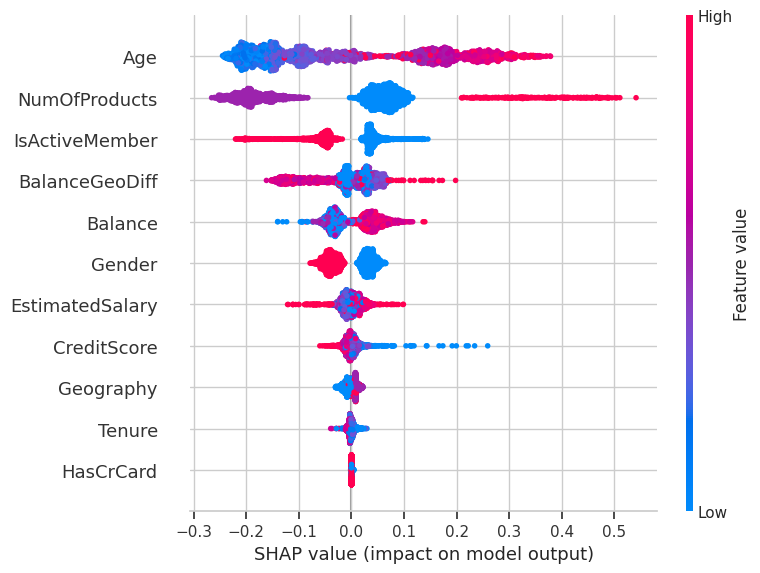

In [124]:
plt.figure()
# Для RandomForestClassifier shap_values может быть списком(берем 1)
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], X_train, feature_names=X.columns, show=False)
else:
    shap.summary_plot(shap_values, X_train, feature_names=X.columns, show=False)
plt.tight_layout()
plt.savefig('images/shap_summary.png', dpi=200, bbox_inches='tight')
plt.show()

Как и в анализе Feature Importance, **Age**, **NumOfProducts** и **IsActiveMember** являются наиболее важными признаками. **BalanceGeoDiff** и **Geography** также входят в число влиятельных. ОДнако есть и отличия.

**Влияние значений признаков:**

  *   **Age:** Высокие значения возраста (красные точки) имеют положительные значения SHAP , что означает, что более старший возраст увеличивает вероятность оттока, в то время как низкие значения возраста (синие точки) имеют отрицательные значения SHAP, уменьшая вероятность оттока.
  *   **NumOfProducts:** Низкие значения NumOfProducts (синие точки) имеют отрицательные значения SHAP, уменьшая вероятность оттока. Высокие значения (красные точки) имеют положительные значения SHAP, увеличивая вероятность оттока, особенно для 3 и 4 продуктов.
  *   **IsActiveMember:** Низкие значения IsActiveMember (синие точки, соответствующие "неактивному") имеют положительные значения SHAP, увеличивая вероятность оттока, а высокие значения (красные точки, соответствующие "активному") имеют отрицательные значения SHAP, уменьшая вероятность оттока.
  *   **BalanceGeoDiff:** Высокие значения BalanceGeoDiff (красные точки), которые означают, что баланс клиента значительно выше среднего по стране, имеют положительные значения SHAP, увеличивая вероятность оттока. Низкие значения (синие точки) имеют отрицательные SHAP.

Таким образом, SHAP summary plot подтверждает, что Age, NumOfProducts и IsActiveMember являются наиболее важными предикторами оттока и наглядно демонстрирует направление их влияния на предсказание.

<Figure size 1000x600 with 0 Axes>

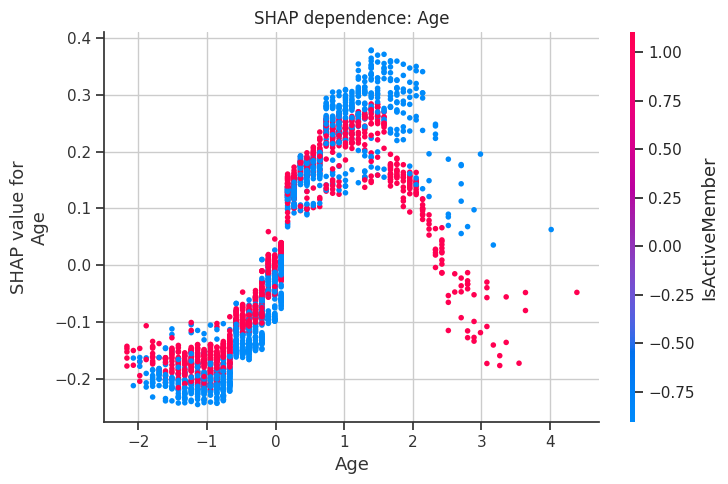

<Figure size 1000x600 with 0 Axes>

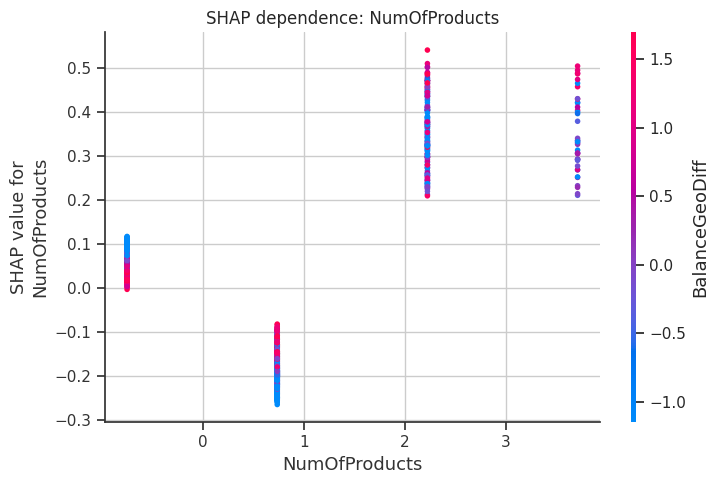

In [125]:
# SHAP dependence plot для топ 2 фич
top2 = feat_imp.index[:2].tolist()
for feat in top2:
    plt.figure()
    try:
        shap.dependence_plot(feat, shap_values[1] if isinstance(shap_values, list) else shap_values, X_train, feature_names=X.columns, show=False)
    except Exception:
        shap.dependence_plot(feat, shap_values, X_train, feature_names=X.columns, show=False)
    plt.title(f'SHAP dependence: {feat}')
    plt.tight_layout()
    plt.savefig(f'images/shap_dependence_{feat}.png', dpi=200)
    plt.show()
    plt.close()

**Выводы по графикам SHAP Dependence Plot:**

Графики SHAP Dependence Plot показывают, как значение SHAP для конкретного признака влияет на предсказание оттока в зависимости от значения самого признака.

*   **Age и IsActiveMember:** С увеличением возраста (особенно после ~40 лет) значения SHAP возрастает, увеличивая вероятность оттока. Более молодой возраст снижает вероятность оттока. Взаимодействие с `IsActiveMember` показывает, что среди средневозростных и пожилых клиентов неактивность сильнее увеличивает вероятность оттока, а активность - значительно снижает, при этом среди молодых высокая активность повышает вероятность оттока.
*   **NumOfProducts и BalanceGeoDiff:** Клиенты с 1 или 2 продуктами в основном имеют отрицательные значения SHAP (снижение вероятности оттока). Клиенты с 3 или 4 продуктами имеют высокие положительные значения SHAP (значительное увеличение вероятности оттока). Взаимодействие с `BalanceGeoDiff` показывает, что среди клиентов с 1 продуктом - высокие показатели баланса уменьшают вероятность оттока, а у клиентов с 2 продуктами - увеличивают.

# 14) Финальные выводы


1.  **Выявление взаимосвязей (EDA и Phik):** Проведенный разведочный анализ данных (EDA) и анализ корреляций (с помощью phik) позволили выявить ключевые признаки, имеющие сильную взаимосвязь с фактом оттока клиента (`Exited`). К таким признакам относятся возраст (`Age`), количество используемых продуктов (`NumOfProducts`), активность клиента (`IsActiveMember`), а также баланс (`Balance`) и географическое положение/разница баланса (`Geography`, `BalanceGeoDiff`). Анализ распределений и взаимосвязей показал, что определенные сегменты клиентов (например, среднего/старшего возраста, с 3+ продуктами, неактивные) имеют более высокую склонность к оттоку.
2.  **Построение модели классификации:** Были обучены и оценены несколько моделей классификации (LogisticRegression, RandomForest, XGBoost) на сбалансированном наборе данных. После подбора гиперпараметров с использованием GridSearchCV, модели RandomForest и XGBoost показали наилучшие результаты по метрикам качества предсказания оттока (в частности, ROC AUC) на тестовой выборке. Модель XGBoost была выбрана как лучшая по совокупности факторов.
3.  **Оценка и интерпретация лучшей модели:**
    *   Окончательная оценка лучшей модели (XGBoost) с использованием Confusion Matrix и Classification Report показала приемлемую точность и сбалансированные метрики Precision и Recall для обоих классов (отток/неотток) на тестовой выборке.
    *   Анализ важности признаков и SHAP-анализ подтвердили результаты EDA, показав, что **Age**, **NumOfProducts** и **IsActiveMember** являются наиболее значимыми предикторами оттока, оказывающими наибольшее влияние на предсказания модели. SHAP-анализ позволил не только определить важность, но и понять направление влияния каждого признака на вероятность оттока для отдельных клиентов.
4.  **Рекомендации на основе анализа:** Полученные в ходе анализа взаимосвязей и интерпретации модели выводы позволяют сформулировать практические рекомендации для бизнеса, направленные на снижение оттока. Рекомендуется сфокусироваться на удержании клиентов из групп риска, выявленных по ключевым признакам (например, разработка персонализированных предложений для клиентов среднего/старшего возраста, программы лояльности для повышения активности, изучение причин ухода клиентов с 3+ продуктами).

Таким образом, проект успешно достиг цели по выявлению взаимосвязей признаков с оттоком и построил эффективную классификационную модель для его предсказания, предоставив ценные инсайты для разработки стратегий удержания клиентов.

In [126]:
# Сохраним лучшие модели и скейлер
joblib.dump(best_rf, 'models/best_rf.joblib')
joblib.dump(best_xgb, 'models/best_xgb.joblib')
joblib.dump(scaler, 'models/scaler.joblib')

['models/scaler.joblib']

Все материалы (графики, модели, таблицы) сохранены в папках: `images/`, `models/`, `model_comparison/`